In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from stable_baselines3 import SAC
from KSEnv import KS_Env
import yaml
from stable_baselines3.common.evaluation import evaluate_policy
from search import newton_search
from KS_stepper_np import cn_ab_solver

In [2]:
def make_env(**kwargs):
    base_args = {
        'L':7,
        'actuator_loss_weight':1,
        'seed':None,
        'device':"cpu",
        'N':32,
        'dt':0.01,
        'max_steps':2500,
        'u0':None,
        'lim':1,
        'plot':True,
        'verbose':True,
        'controller':'nonlin',
        'sees_state':True,
        'observation_type':'state',
        'reward_type':'trivial',
        'pullback_state':True,
        'noise':0,
        'initial_amp': 0.1,
        'continuous':False
    }

    base_args.update(kwargs)

    return KS_Env(**base_args)

In [3]:
def test(model_path, env_path, num_episodes=10, plot=True, unforced=True):
    
    with open(env_path, 'r') as f:
        config = yaml.safe_load(f)
    env_args = config['env']
    env_args['plot'] = plot
    env_args['actuator_loss_weight'] = 0.0


    env = make_env(**env_args)
    model = SAC.load(model_path, env=env)    

    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=num_episodes, deterministic=True)

    steps = env_args['max_steps']

    if unforced:
        env_args2 = env_args.copy()
        env_args2['controller'] = 'unforced'

        env2 = make_env(**env_args2)
        model2 = SAC.load(model_path, env=env2)

        mean_reward2, std_reward2 = evaluate_policy(model2, env2, n_eval_episodes=num_episodes, deterministic=True)

    steps = env_args['max_steps']

    print(f"Mean reward: {mean_reward/steps}, Std reward: {std_reward/steps}")
    if unforced:
        print(f"Unforced mean reward: {mean_reward2/steps}, Std reward: {std_reward2/steps}")
    if env_args['controller'] == 'fully_linear':
        K = model.actor.mu.weight.data.cpu().numpy()
        # np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True, precision=4)
        # print(f"Controller gain matrix K:\n{K}")
        return K


In [4]:
def ens_test(model_paths, env_path, num_episodes=10, plot=True, unforced=True):

    models = []
    
    with open(env_path, 'r') as f:
        config = yaml.safe_load(f)
    env_args = config['env']
    env_args['plot'] = plot
    env_args['actuator_loss_weight'] = 0.0

    env = make_env(**env_args)
    models = []
    for model_path in model_paths:
        model = SAC.load(model_path, env=env)    
        models.append(model)


    env.evaluate_ens_model(models, num_episodes = num_episodes, compare=True)


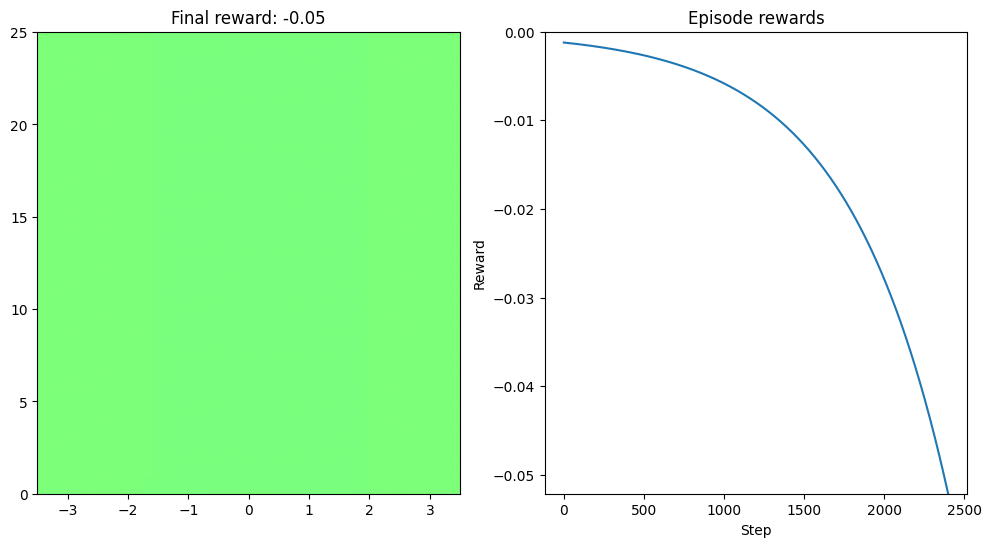

Unforced rewards: -0.15122902631031268
Forced rewards: -0.1089266687631607


In [6]:
model_paths = ["runs/linear_ens0.zip", "runs/linear_ens1.zip", "runs/linear_ens2.zip", "runs/linear_ens3.zip"]
env_path = "configs/config_linear.yaml"
ens_test(model_paths, env_path, num_episodes=2, plot=True, unforced=True)

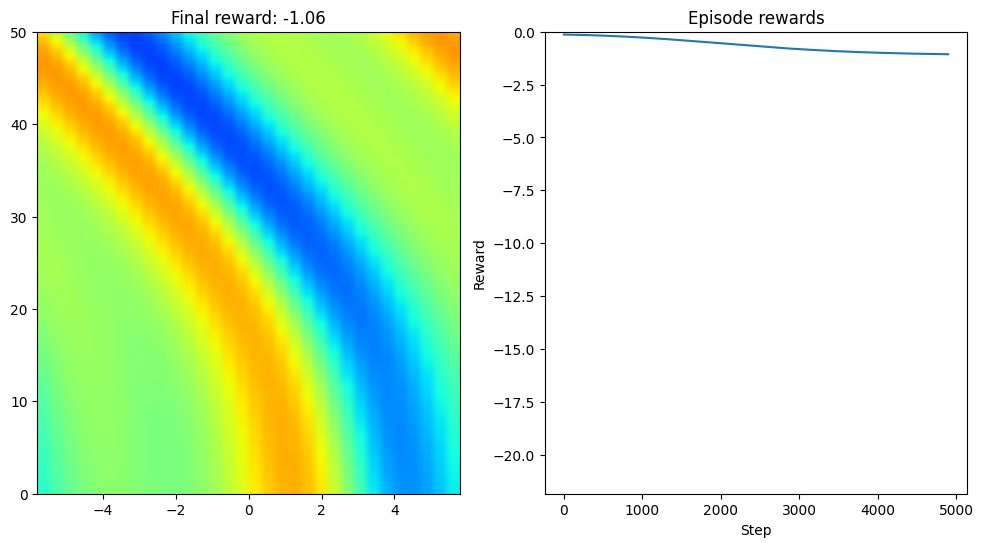

Unforced rewards: -0.5261502115339348
Forced rewards: -1.2505508661270142


In [7]:
model_paths = ["runs/nonlin_time6_ens0.zip", "runs/nonlin_time6_ens1.zip", "runs/nonlin_time6_ens2.zip"]
env_path = "configs/config_nonlin_time6.yaml"
ens_test(model_paths, env_path, num_episodes=10, plot=True, unforced=True)

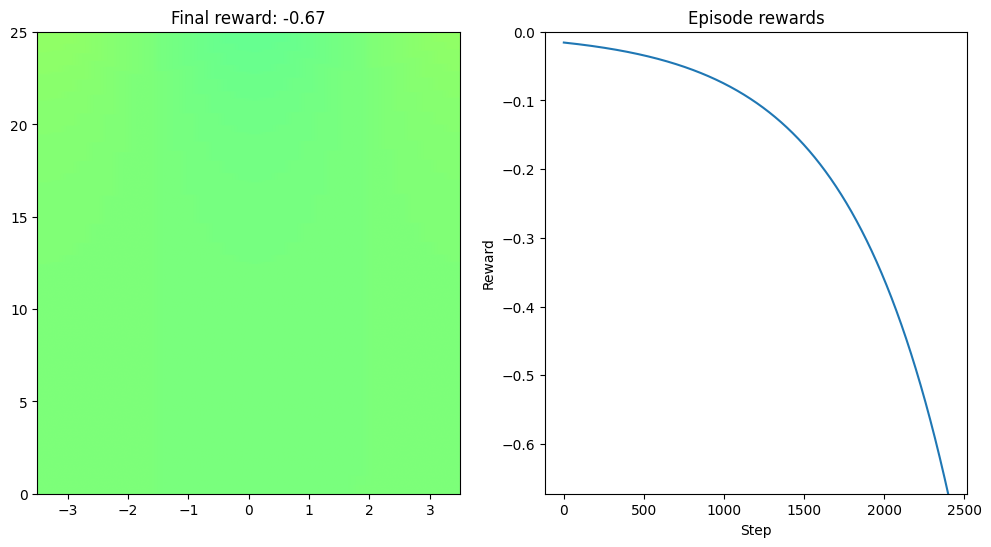

Mean reward: -0.4567505882084317, Std reward: 0.29526267201235995
Unforced mean reward: -0.23531299372651265, Std reward: 0.18676301704836507


In [7]:
K = test('runs/linear_ens0.zip', 'configs/config_linear.yaml', num_episodes=10, plot=True)

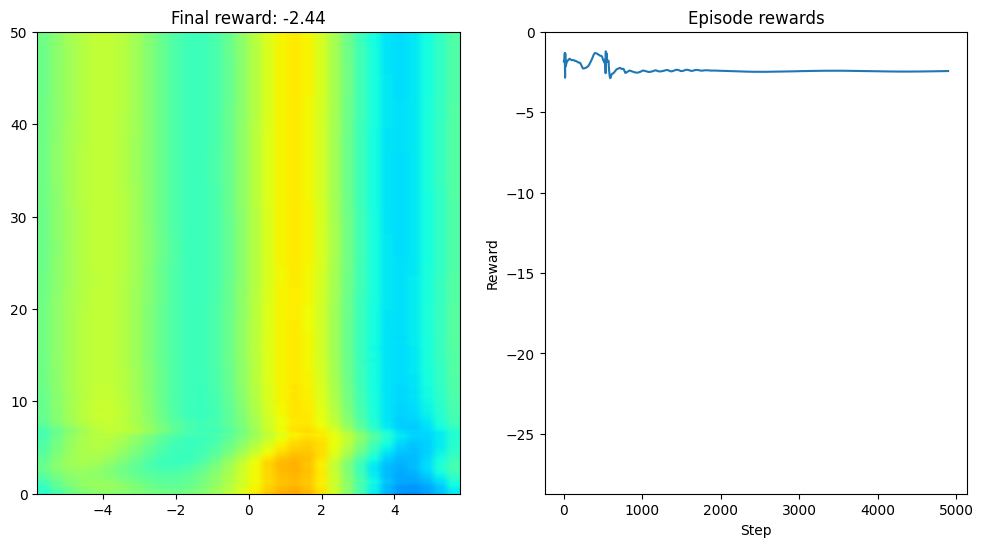

KeyboardInterrupt: 

In [8]:
test("runs/nonlin_time6_ens1.zip", "configs/config_nonlin_time6.yaml", num_episodes=10, plot=True)

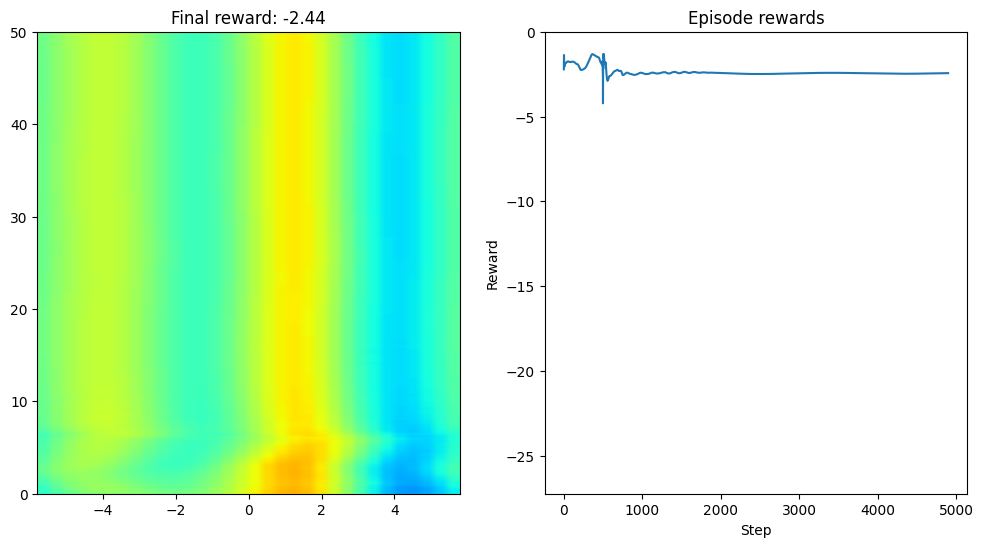

In [ ]:
with open("configs/config_nonlin_time6.yaml", 'r') as f:
    config = yaml.safe_load(f)
env_args = config['env']
env_args['plot'] = True
env_args['actuator_loss_weight'] = 0.0
env_args['seed'] = 43
env = make_env(**env_args)
model = SAC.load("runs/nonlin_time6_ens1.zip", env=env, seed=43)
obs, _ = env.reset()
for _ in range(5000):
    action, _ = model.predict(obs, deterministic=True)
    action2 = np.zeros_like(action)
    obs, reward, done, info, _ = env.step(action)


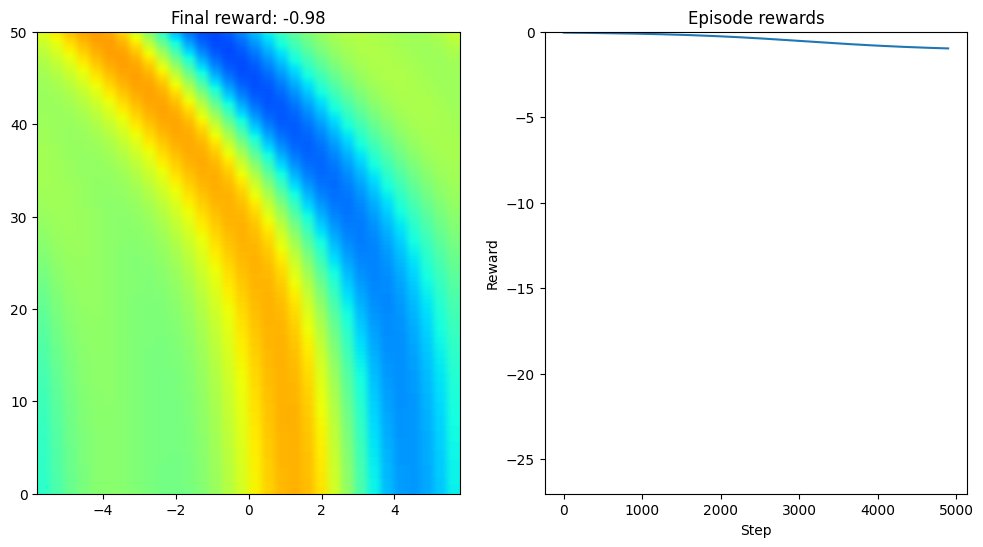

In [ ]:
with open("configs/config_nonlin_time6.yaml", 'r') as f:
    config = yaml.safe_load(f)
env_args = config['env']
env_args['plot'] = True
env_args['actuator_loss_weight'] = 0.0
env_args['seed'] = 43
env = make_env(**env_args)
model = SAC.load("runs/nonlin_time6_ens1.zip", env=env, seed=43)
obs, _ = env.reset()
for _ in range(5000):
    action, _ = model.predict(obs, deterministic=True)
    action2 = np.zeros_like(action)
    obs, reward, done, info, _ = env.step(action2)
